# Building a simple Spotify track popularity predictor


In [1]:
# Data understanding and preparation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# load the data 
df = pd.read_csv('spotify_tracks.csv')

# check for missing values
print(df.isnull().sum())

# check unique values in categorical columns
print(df['genre'].value_counts())
print(df['explicit'].value_counts())


id             0
name           0
genre          0
artists        0
album          0
popularity     0
duration_ms    0
explicit       0
dtype: int64
genre
acoustic             50
new-age              50
punk                 50
psych-rock           50
progressive-house    50
                     ..
french               50
forro                50
folk                 50
emo                  50
world-music          50
Name: count, Length: 126, dtype: int64
explicit
False    5106
True     1194
Name: count, dtype: int64


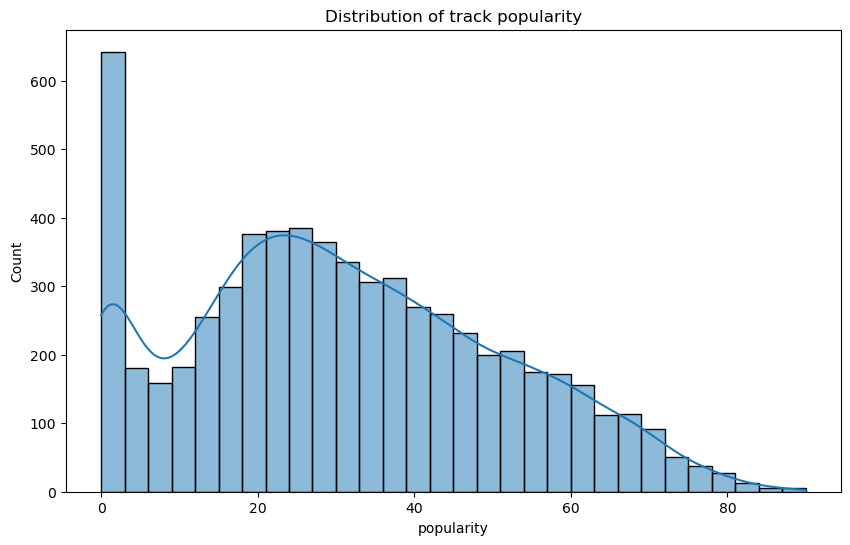

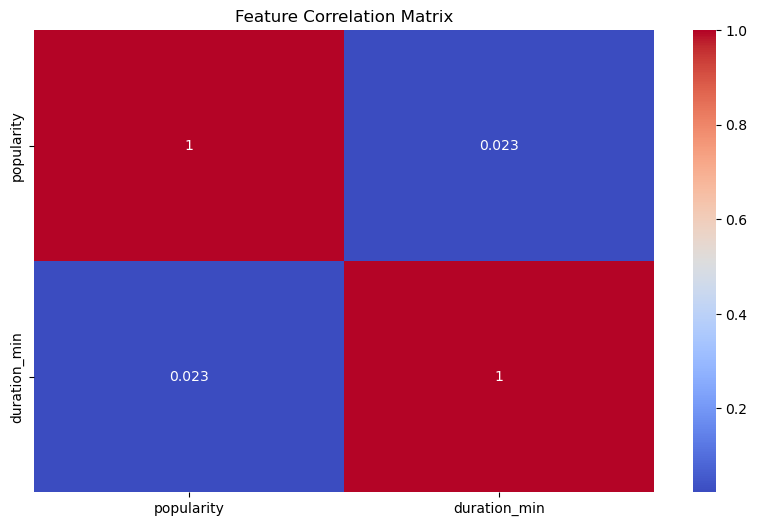

In [2]:
# Feature Engineering

# Feature selection - we'll use genre, duration_ms, and explicit to predict popularity
# Drop columns we won't use
df = df[['genre', 'duration_ms',  'explicit', 'popularity']].copy()
df = df.dropna()

# Convert duration from milliseconds to minutes for better interpretability
df['duration_min'] = df['duration_ms'] / 60000
df = df.drop('duration_ms', axis=1)

# convert explicit to numeric
df['explicit'] = df['explicit'].astype(int)

# distribution of popularity
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Distribution of track popularity')
plt.show()

#check correlation between numerical features
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [3]:
# Data Preprocessing Pipeline 

#separate features and target
X = df.drop('popularity', axis=1)
y = df['popularity']

#split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#define preprocessing steps
numeric_features = ['duration_min']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['genre', 'explicit']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# add classifier/regressor to pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [4]:
# model training and evaluation

#train the model
model.fit(X_train, y_train)

#make predictions
y_pred = model.predict(X_test)

#evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


Model Performance:
RMSE: 17.45
R2: 0.24


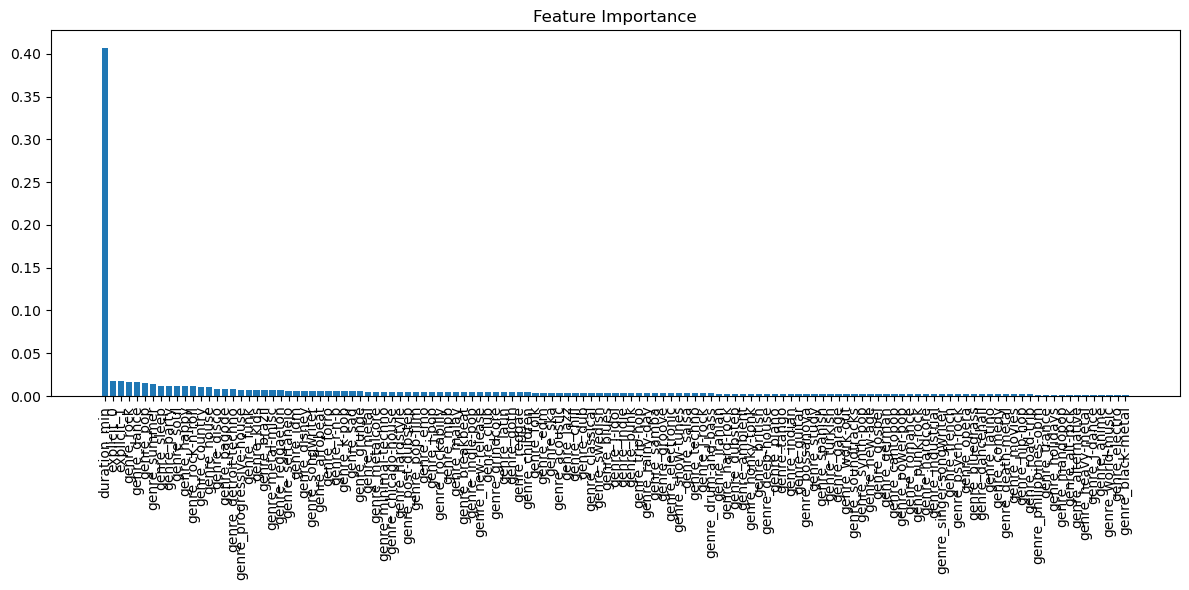

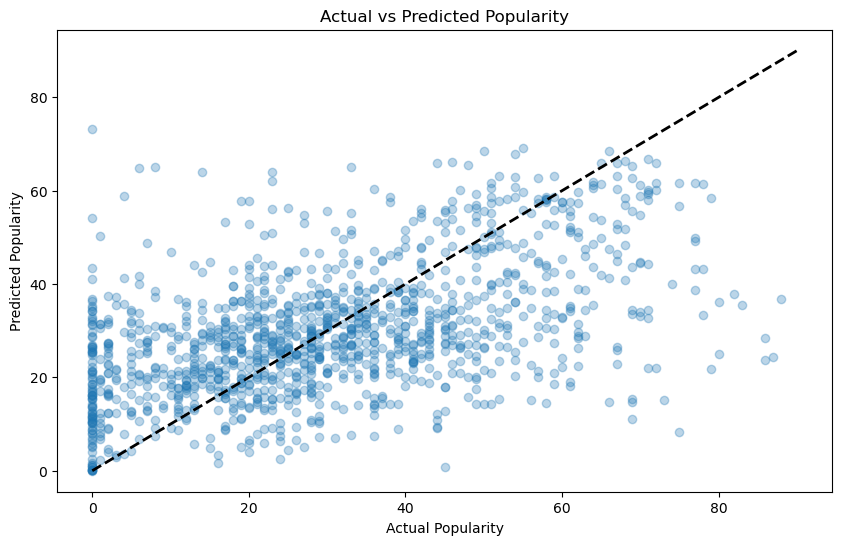

In [5]:
# Feature importance (for Random Forest)
# Get feature names after one-hot encoding
feature_names = numeric_features.copy()
ohe_categories = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(ohe_categories)

# Get feature importances
importances = model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

#plot feature importance
plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# actual vs predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Actual vs Predicted Popularity')
plt.show()

In [6]:
# Model Deployment

def predict_popularity(genre, duration_min, explicit):
    """
    Predicts Spotify track popularity based on genre, duration, and explicit flag
    
    Parameters:
    genre (str): The genre of the track
    duration_min (float): Duration of the track in minutes
    explicit (bool): Whether the track contains explicit content
    
    Returns:
    float: Predicted popularity score
    """
    # Create input DataFrame
    input_data = pd.DataFrame({
        'genre': [genre],
        'duration_min': [duration_min],
        'explicit': [int(explicit)]
    })
    
    # Make prediction
    prediction = model.predict(input_data)
    
    return prediction[0]

# Example usage
print("Predicted popularity:", predict_popularity(genre='new_age', duration_min=3.5, explicit=False))

Predicted popularity: 31.03


In [7]:
# Saving the model

import joblib

# Save the model
joblib.dump(model, 'spotify_popularity_predictor.joblib')

# To load the model later:
# loaded_model = joblib.load('spotify_popularity_predictor.joblib')

['spotify_popularity_predictor.joblib']